#### Vehicle Detection Project

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a Linear SVM classifier
- Apply a color transform and append binned color features, as well as histograms of color, to the  HOG feature vector.
- Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
- Run the pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

In [1]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import time

from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

%matplotlib inline

### Load the car and not car images
- First we load the car and not car images for the purpose of training the SVM classifier
- The code below prints the number of car and not car images we have in the training set
- Each image is in the RGB format and of shape 64x64

In [2]:
cars = []
notcars = []

images = glob.glob("data/vehicles/*/*.png")
for i in images:
    cars.append(i)
    
images = glob.glob("data/non-vehicles/*/*.png")
for i in images:
    notcars.append(i)
    
print("cars images %d" % len(cars))
print("notcars images %d" % len(notcars))

car_idx = np.random.randint(0, len(cars))
notcar_idx = np.random.randint(0, len(notcars))
print("Cars shape", mpimg.imread(cars[car_idx]).shape)
print("Not Cars shape", mpimg.imread(cars[notcar_idx]).shape)

cars images 8792
notcars images 8968
Cars shape (64, 64, 3)
Not Cars shape (64, 64, 3)


### Visualiaze few car and "not car" images
- Lets take a look at some of the car and not car images

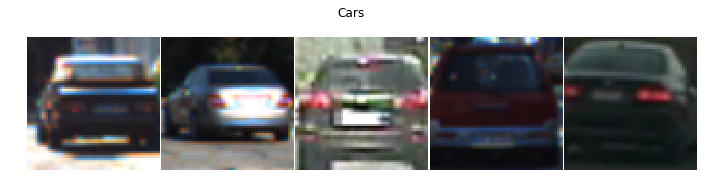

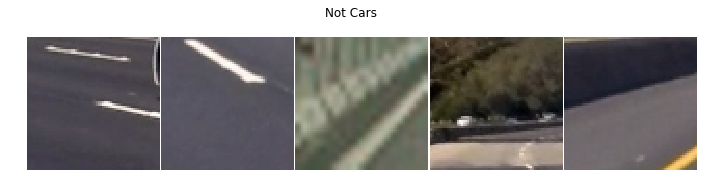

In [3]:
def display_rand_images(images, title, num_img, nrows=1):
    ncols = num_img // nrows
    plt.figure(figsize=(12, 8))
    plt.suptitle(title)
    plt.subplots_adjust(top=1.5, wspace=0.01)
    indexes = np.random.randint(len(images), size=num_img)

    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j
            img = mpimg.imread(images[indexes[idx]])
            plt.subplot(nrows, ncols, idx + 1)
            plt.imshow(img)
            plt.axis('off')

    # plt.tight_layout()
    plt.show()

display_rand_images(cars, "Cars", 5)
display_rand_images(notcars, "Not Cars", 5)

### Functions to create different types of features

In [9]:
def convert_color(img, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            out_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            out_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            out_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            out_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == "YCrCb":
            out_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        out_image = np.copy(image)
        
    return out_image

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(
            img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), visualise=True, 
            feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(
            img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), visualise=False, 
            feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, )
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Visualize HOG transform

- Next we visualize the HOG features
- From the pictures below it is obvious that the HOG features often shows the boundaries of the car

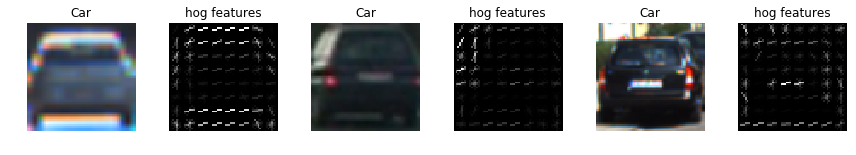

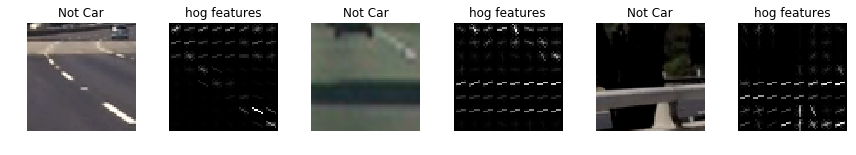

In [5]:
orient = 9
pix_per_cell = 8
cell_per_block = 2


def display_hog_transform(images, title, num_img, nrows=1):
    ncols = num_img // nrows
    plt.figure(figsize=(12, 10))
    indexes = np.random.randint(len(images), size=num_img)

    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j
            img = mpimg.imread(images[indexes[idx]])
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            
            _, hog_img = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True)
            
            ax1 = plt.subplot(nrows, 2 * ncols, 2 * idx + 1)
            plt.imshow(img)
            ax1.set_title(title)
            plt.axis("off")
            
            ax2 = plt.subplot(nrows, 2 * ncols, 2 * idx + 2)
            plt.imshow(hog_img, cmap='gray')
            ax2.set_title("hog features")
            plt.axis("off")

    plt.tight_layout()
    plt.show()
    
display_hog_transform(cars, "Car", 3)
display_hog_transform(notcars, "Not Car", 3)

In [6]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):

    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, cspace)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        
                # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        
        
    # Return list of feature vectors
    return features

### Train a classifier
- Extract features, there are altogether 8460 features
- Train a linear classier SVM
- We randomly split the data into 80% for train and remaining 20% for testing

In [7]:
def train_classifier(svc, cars, notcars, cspace, spatial_size=(32, 32), hist_bins=32,
                    orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    t=time.time()

    car_features = extract_features(
        cars, cspace, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

    notcar_features = extract_features(
        notcars, cspace, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
    
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)

    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    print("Shape of X and Y", X.shape, y.shape)

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))

    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')

    test_accuracy = round(svc.score(X_test, y_test), 4)
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', test_accuracy)
    # Check the prediction time for a single sample
    t=time.time()

    return X_scaler, test_accuracy

In [16]:
cspaces = ['HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
test_accuracy = []

for cspace in cspaces:
    print("Training classifier for " + cspace)

    svc = LinearSVC()
    _, accuracy = train_classifier(svc, cars, notcars, cspace)
    test_accuracy.append(accuracy)

Training classifier for HSV
74.67 Seconds to extract HOG features...
Shape of X and Y (17760, 8460) (17760,)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
5.53 Seconds to train SVC...
Test Accuracy of SVC =  0.9899
Training classifier for LUV
72.15 Seconds to extract HOG features...
Shape of X and Y (17760, 8460) (17760,)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
24.31 Seconds to train SVC...
Test Accuracy of SVC =  0.9907
Training classifier for HLS
72.79 Seconds to extract HOG features...
Shape of X and Y (17760, 8460) (17760,)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
4.58 Seconds to train SVC...
Test Accuracy of SVC =  0.989
Training classifier for YUV
71.53 Seconds to extract HOG features...
Shape of X and Y (17760, 8460) (17760,)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
5.89 Seconds to train SV

### The test accuracy in different colorspace is as follows

Color Space | Test Accuracy
--- | --- 
HSV | 0.9918
LUV | 0.9904
HLS | 0.9910
YUV | 0.9913
YCrCb | 0.9935

We can that the colorsapce YCrCb achieves the highest accuracy. So we will use that colorspace to draw the bounding boxes.

### The model parameters used are as follows
The parameters have been derived after some experimentation

#### Color features
- colorspace = YCrCb
- spatial_size=(32, 32)
- hist_bins=32

#### HOG Features
- orient=9
- pix_per_cell=8
- cell_per_block=2
- hog_channel='ALL'

In [17]:
svc = LinearSVC()
colorsapce = "YCrCb"
X_scaler, accuracy = train_classifier(svc, cars, notcars, cspace)

67.62 Seconds to extract HOG features...
Shape of X and Y (17760, 8460) (17760,)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
9.91 Seconds to train SVC...
Test Accuracy of SVC =  0.9899


### Sliding Window Search

Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

- I have adopted the method find_cars as provided in the course lecture
- I have made few modifications to the method, for example accept colorspace as a parameter, create and return heatmap etc.
- The code performs HOG transform only once for the image
- The sliding window is run between ystart and ystop and at every 2 cells which is equivalent to 16 pixels
- For each window, it extracts the features, uses SVM classifier to predict whether the window contains a car or not.
- If the window contains car then it updates the heatmap and also draws recentagle around the window
- Below I have shown some pictures with the detected car window

In [18]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
              cell_per_block, spatial_size, hist_bins, cspace='YCrCb'):

    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:, :, 0]).astype(np.float)

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, cspace)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(
            ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = 1 + (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = 1 + (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction            
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
                heatmap[ytop_draw+ystart:ytop_draw + ystart + win_draw, xbox_left:xbox_left + win_draw, ] = 1

    return draw_img, heatmap

In [19]:
def draw_labeled_bboxes(img, heatmap):
    draw_img = np.copy(img)
    labels = label(heatmap)

    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(draw_img, bbox[0], bbox[1], (0, 255, 0), 8)
    # Return the image
    return draw_img

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



test_images/test1.jpg


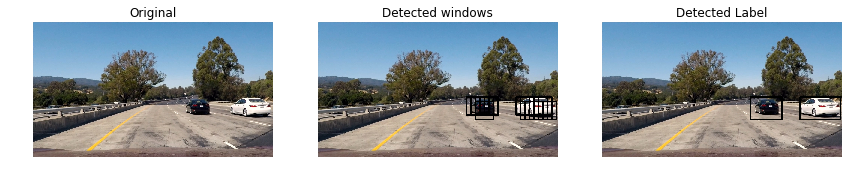

test_images/test2.jpg


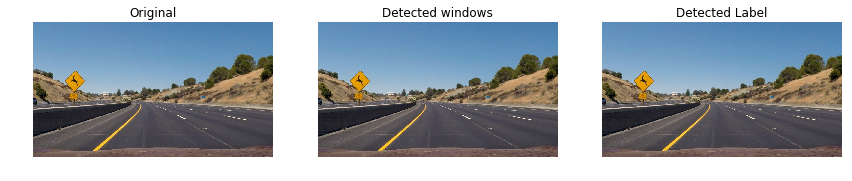

test_images/test3.jpg


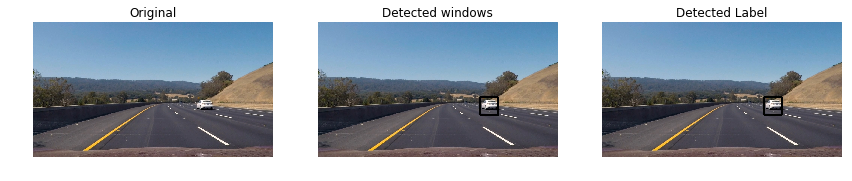

test_images/test4.jpg


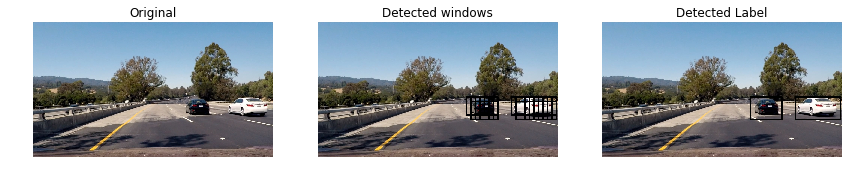

test_images/test5.jpg


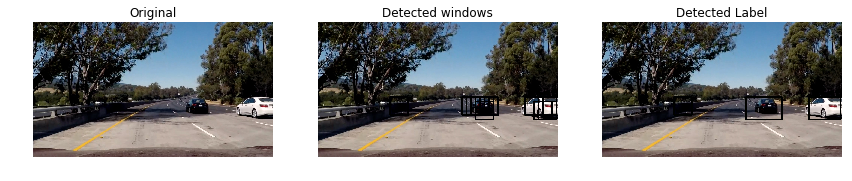

test_images/test6.jpg


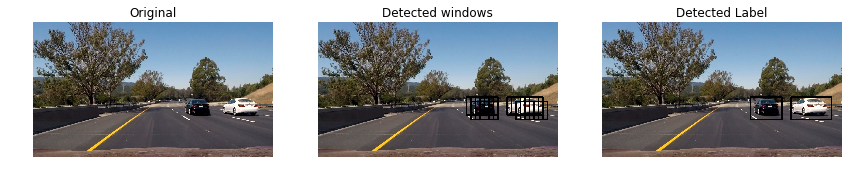

In [36]:
ystart = 400
ystop = 700
scale = 1.5

colorspace = 'YCrCb'
spatial_size=(32, 32)
hist_bins=32


images = glob.glob("test_images/*.jpg")

for file_name in images:
    img = mpimg.imread(file_name)
    img = img.astype(np.float32) / 255
    
    car_img, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
                                 cell_per_block, spatial_size, hist_bins, cspace=colorspace)

    labeled_img = draw_labeled_bboxes(img, heatmap)

    print(file_name)
    plt.figure(figsize=(12, 8))
    ax1 = plt.subplot(131)
    plt.imshow(img)
    ax1.set_title("Original")
    plt.axis("off")
    
    ax2 = plt.subplot(132)
    ax2.set_title("Detected windows")
    plt.imshow(car_img)
    plt.axis("off")
    
    ax3 = plt.subplot(133)
    ax3.set_title("Detected Label")
    plt.imshow(labeled_img)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

### Video Implementation

1. Provide a link to your final video output.

    - [test_video.mp4](/test_video_out.mp4)
    - [project_video.mp4](/project_video_out.mp4)

2. Describe how you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

To remove false positives I look at last 15 frames of the video and remove window of heatmap that does not appear in at least 5 frames. More specifically

- I identify the heatmap for each frame
- Add the heatmaps of last 15 frames
- Set any heat <= 5 to zero
- The car windows are constructed from the remaining heats

In [29]:
class PastHeatMaps:
    
    def __init__(self, num_frames = 15):
        self._heatmaps = []
        self._heatmap_sum = None
        self._num_frames = num_frames
        
    def add_heatmap(self, heatmap):
        if self._heatmap_sum is None:
            self._heatmap_sum = heatmap
        else:
            self._heatmap_sum += heatmap
            
        self._heatmaps.append(heatmap)
        if len(self._heatmaps) > self._num_frames:
            self._heatmap_sum -= self._heatmaps[0]
            self._heatmaps = self._heatmaps[-self._num_frames: ]
            
    def apply_threshold(self, heatmap):
        self.add_heatmap(heatmap)
        
        threshold = len(self._heatmaps) // 3
        new_heatmap = np.copy(self._heatmap_sum)
        new_heatmap[new_heatmap <= threshold] = 0
        
        return new_heatmap

def process_frame(img):
    ystart = 400
    ystop = 700
    scales = [1, 1.5, 2]
    
    scaled_img = img.astype(np.float32) / 255
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)

    for scale in scales:
        car_img, heat = find_cars(scaled_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
                                  cell_per_block, spatial_size, hist_bins, cspace=colorspace)
        heatmap += heat
    
    heatmap = past_heatmaps.apply_threshold(heatmap)
    labeled_img = draw_labeled_bboxes(img, heatmap)
    return labeled_img

In [30]:
past_heatmaps = PastHeatMaps()

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [01:00<00:01,  1.60s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 59 s, sys: 2.21 s, total: 1min 1s
Wall time: 1min 1s


In [38]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [32]:
past_heatmaps = PastHeatMaps()

prj_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(prj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [32:46<00:01,  1.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 31min 48s, sys: 1min 14s, total: 33min 3s
Wall time: 32min 47s


In [37]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(prj_out_file))

### Discussion

Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

- The problem I faced in tuning different parameters to find the optimal combination. There are many parameters used in the project, spatial size, histogram bins, HOG parameters etc. Exploring all combinations of those was a tedious task

The method is likely to fail in the following scenarios

- Vehicle significantly different than what is available in the training data (e.g. sport car)
- Different lightening and weather conditions when the vehicles are not visible properly
- Smaller car in far way distant
- There could be false positives for vehicles coming from opposite directions and no proper lane markings available

I believe the best approach to tackle some of the above problems will be

- Use more advanced model like CNN which will be much more robust'
- Generate more training data by changing the color, intensity values of the training set
- Incorporate speed information to track the vehicles more accurately